In [112]:
import pandas as pd
import numpy as np

from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

from astropy import units as u
from astropy import coordinates as coord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.utils.data import get_pkg_data_filename

from urllib.request import urlretrieve

# R -> The distance from the centre
# t -> The time
# D -> Diffusion coefficient
# E is the energy, no energy is lost in this system

## Define the following functions
dN/dE represents the distribution of energies, and can be calculated with the following formula. 

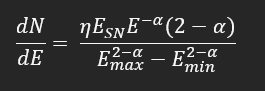

In [113]:
@u.quantity_input(E = u.erg)
def dNdE(E, Emax = 5*u.PeV, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 2.7):
    dNdE = (eta*Esn*(-alpha+2))/(Emax**(2-alpha)-Emin**(2-alpha))*E**-alpha
    return dNdE

Rshell shows the radius of the shockfront of the supernova remenant. For this model, Rshell is where the where the particles are injected into the model. This results in the distribution function being 0 for R < Rshell.
The following formula is used to find Rshell.

![Rshell formula.png](<attachment:Rshell formula.png>)

In [114]:
@u.quantity_input(t=u.yr, E=u.eV)
def Rshell(E, n0=10/u.cm**3, Esn=1e52*u.erg, Emax = 5*u.PeV, beta = 2.48):
    R = 0.31*(Esn/(1e51*u.erg))**(1/5)*(n0/(u.cm**-3))**(-1/5)*(Tesc(E, Emax, beta)/u.yr)**(2/5) *u.pc
    return R.to(u.pc)

Tesc represents the time taken for the average particle at a given energy to pass the shock front of the supernova remenant. Similar to Rshell, the distribution function is 0 for T < Tesc. This can be calculated using the following formula.

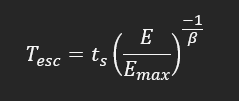

In [115]:
@u.quantity_input(E=u.erg)
def Tesc(E, Emax = 5*u.PeV, beta = 2.48, ts = 1600*u.yr):
    return (ts*(E/Emax)**(-1/beta)).to(u.yr)    

The diffudsion coefficient dictates how fast the particles will diffuse through space. This can be calculated as follows.

$$ D(E) = [0.1, 0.5] \times 10^{28} \left( \frac{E}{10 GeV} \right)^{\frac12} \left( \frac{B}{3 \mu G} \right)^{-\frac12} cm^2 s^{-1} $$

In [116]:
@u.quantity_input(E=u.erg)
def diffusion(E, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1 ):
    dif = x * Dn * ((3*E/(u.GeV))/(10*B/(u.uG)))**delta
    return dif * u.cm**2 * u.s**-1

The distribution shows the spread of particles at any given radius greater than Rshell,any time greater then tesc and any energy. The function outputs in units of per energy per unit volume. Rdiff shows the radius of the sphere up to which the particles of energy E effectivly propogate to in time t. The distribution and Rdiff can be calculated with the following formulea.

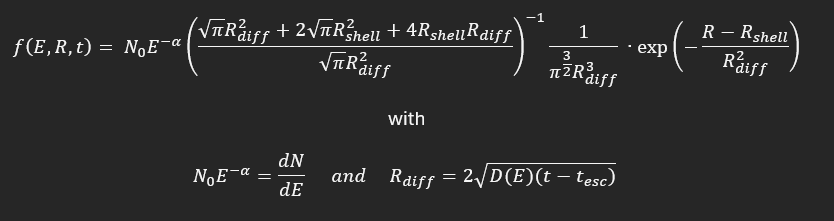

In [117]:
@u.quantity_input(E=u.erg, R=u.pc, t=u.yr, Emax=u.erg, Emin=u.erg, Esn=u.erg, B=u.G, ts=u.yr, n0=u.cm**-3)
def distribution(E, R, t, Emax = 5*u.PeV, Emin=1*u.GeV, eta = 0.25, Esn = 1e52*u.erg, alpha = 2.7, B = 50 * u.uG, x = 0.1, delta = 0.5, Dn = 3e27 * 0.1, beta = 2.48, ts = 1600*u.yr, n0=10/u.cm**3):
    Rdif = 2 * np.sqrt(diffusion(E, B, x, delta, Dn) * (t - Tesc(E, Emax, beta, ts)))

    first1 = (np.pi**(1/2))*(Rdif**2) 
    first2 = 2*(np.pi**(1/2)*(Rshell(E, n0, Esn, Emax, beta))**2) 
    first3 = 4*Rshell(E, n0, Esn, Emax, beta)*(Rdif)
    
    firstT = first1 + first2 + first3

    dist = dNdE(E, Emax, Emin, eta, Esn, alpha)*(firstT/(np.pi**(1/2)*(Rdif)**2))**(-1)*(1/(np.pi**(3/2)*(Rdif)**3))*np.exp(-(R-Rshell(E, n0, Esn, Emax, beta))**2/(Rdif)**2)

    return dist.to(1/(u.TeV * u.cm**3))

Take input from user

In [118]:
# E_input = float(input("At what energy ? ").strip())
# if(E_input == 0):
#     E_input = 5*u.TeV

# T_input = float(input("At what time ? ").strip())
# if(T_input == 0):
#     T_input = 50*u.kyr

# R_input = float(input("At what radius ? ").strip())
# if(R_input == 0):
#     R_input = 50*u.pc

Plotting against R

Text(0.5, 1.0, 'Particle distribution against radius')

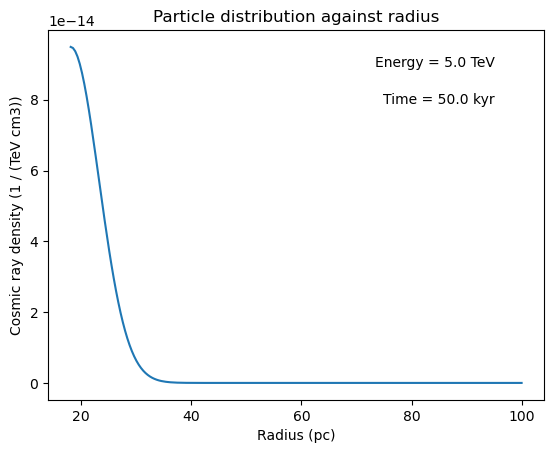

In [245]:
Rs = np.linspace(Rshell(E_input), 100*u.pc, 200)

plt.plot(Rs, distribution(E_input, Rs, T_input))

plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E_input, Rs, T_input).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius")


Plotting against t

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Particle distribution against time')

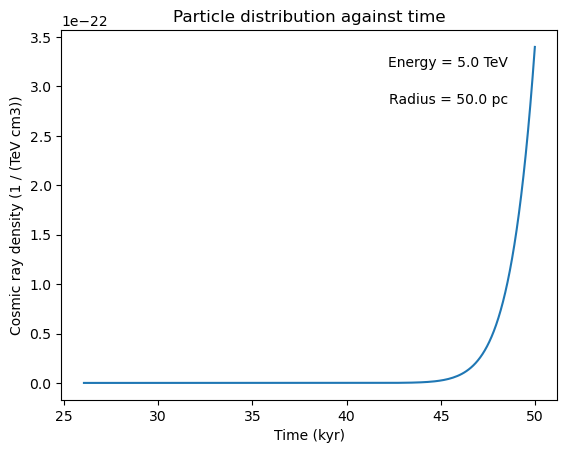

In [246]:
ts = np.linspace(Tesc(E_input).to(u.kyr).value, (50*u.kyr).to(u.kyr).value, 200)*u.kyr


plt.plot(ts, distribution(E_input, R_input, ts))

plt.xlabel(f"Time ({ts.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E_input, R_input, ts).unit})")
plt.text(0.9, 0.9, f"Energy = {E_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against time")


#plt.yscale("log")

Plotting against E

Text(0.5, 1.0, 'Particle distribution against energy')

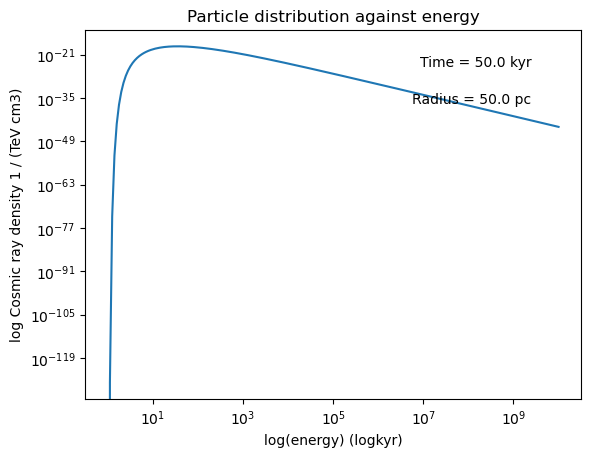

In [247]:
Es = np.logspace(0, 10, 200)*u.TeV

plt.plot(Es, distribution(Es, R_input, T_input))
plt.yscale("log")
plt.xscale("log")

plt.xlabel(f"log(energy) (log{ts.unit})")
plt.ylabel(f"log Cosmic ray density {distribution([E_input]*u.TeV, R_input, T).unit}")
plt.text(0.9, 0.9, f"Time = {T_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R_input}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")


## Any further plots can be made below for hard coded t, R and E. Existing linspaces of ts, Rs and logspace Es can be used, or new ones made

In [248]:
a = np.linspace(1, 10)
mask = a > 5
a[mask]

array([ 5.04081633,  5.2244898 ,  5.40816327,  5.59183673,  5.7755102 ,
        5.95918367,  6.14285714,  6.32653061,  6.51020408,  6.69387755,
        6.87755102,  7.06122449,  7.24489796,  7.42857143,  7.6122449 ,
        7.79591837,  7.97959184,  8.16326531,  8.34693878,  8.53061224,
        8.71428571,  8.89795918,  9.08163265,  9.26530612,  9.44897959,
        9.63265306,  9.81632653, 10.        ])

Plotting against energy as time progresses

C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Particle distribution against energy')

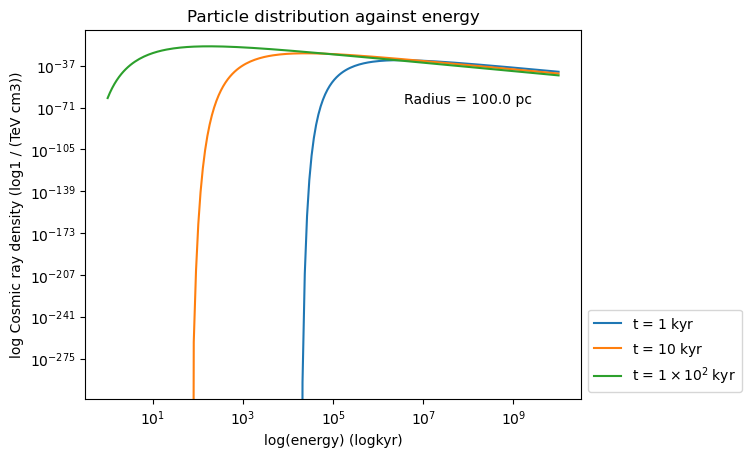

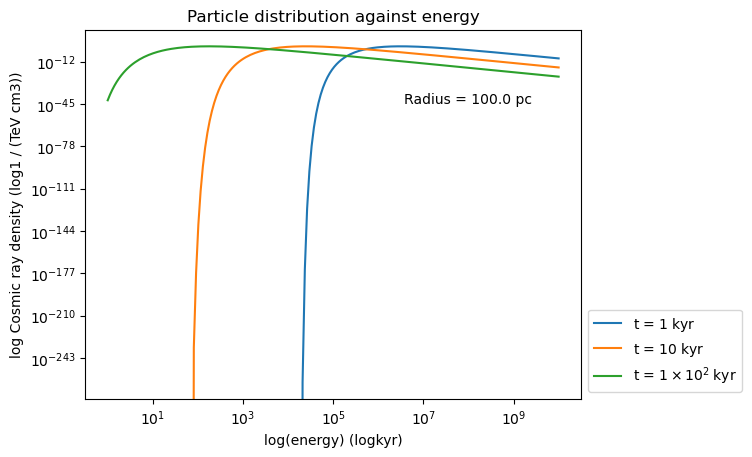

In [249]:
Es = np.logspace(0, 10, 200)*u.TeV
R = 100*u.pc
T = [1, 10, 100] *u.kyr


plt.figure()
for i in T:
    plt.plot(Es, distribution(Es, R, i), label=f"t = {i.to_string(format='latex', precision=2)}")
plt.yscale("log")
plt.xscale("log")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"log(energy) (log{ts.unit})")
plt.ylabel(f"log Cosmic ray density (log{distribution(Es[0], R, T).unit})")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")

plt.figure()
for i in T:
    plt.plot(Es, distribution(Es, R, i)/np.nanmax(distribution(Es, R, i)), label=f"t = {i.to_string(format='latex', precision=2)}")
plt.yscale("log")
plt.xscale("log")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"log(energy) (log{ts.unit})")
plt.ylabel(f"log Cosmic ray density (log{distribution(Es[0], R, T).unit})")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against energy")

Plotting radius as time progresses

Text(0.5, 1.0, 'Particle distribution against radius')

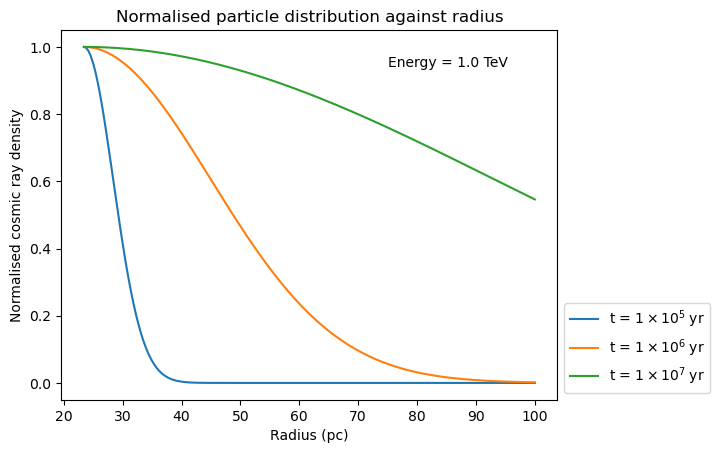

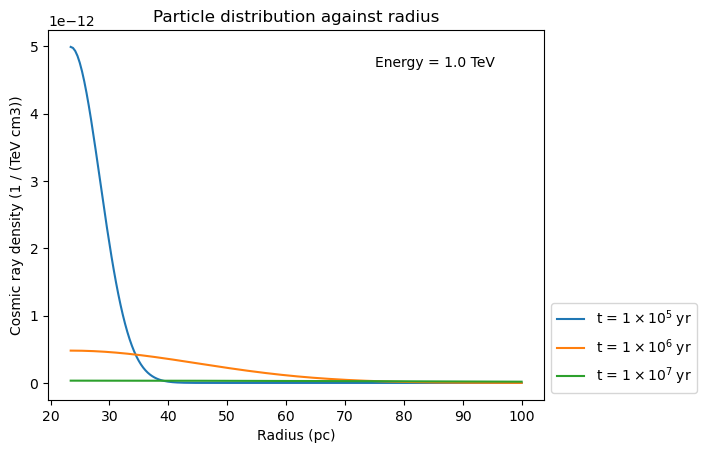

In [250]:
E = 1 * u.TeV
Rs = np.linspace(Rshell(E), 100*u.pc, 200)

T = [1e5, 1e6, 1e7] * u.yr

plt.figure()

for i in T:
    plt.plot(Rs, distribution(E, Rs, i)/np.max(distribution(E, Rs, i)), label=f"t = {i.to_string(format='latex', precision=2)}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Normalised cosmic ray density")
plt.text(0.9, 0.9, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Normalised particle distribution against radius")

plt.figure()

for i in T:
    plt.plot(Rs, distribution(E, Rs, i), label=f"t = {i.to_string(format='latex', precision=2)}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E, Rs[0], T).unit})")
plt.text(0.9, 0.9, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius")

Changing alpha

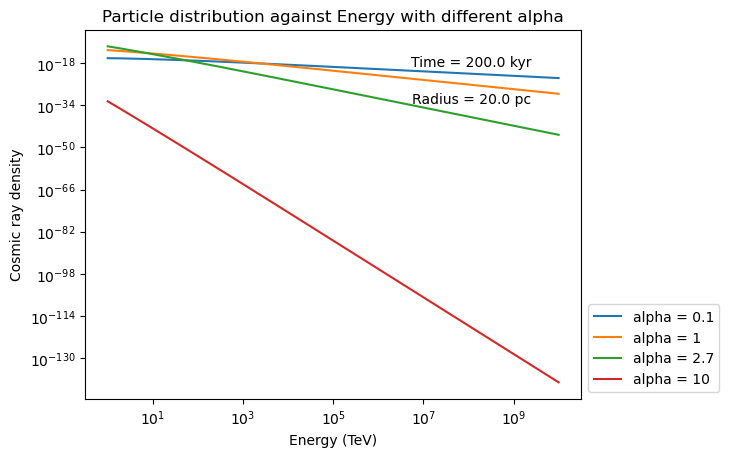

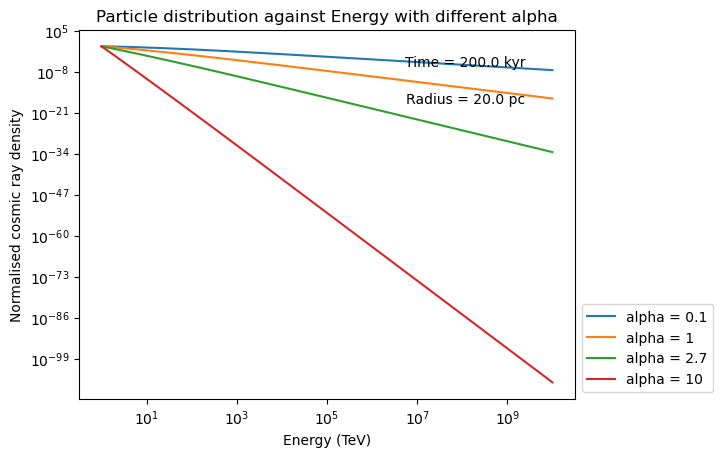

In [251]:
t = 200*u.kyr
R = 20*u.pc 

alpha = [0.1, 1, 2.7, 10]

plt.figure()
for i in alpha:
    plt.plot(Es, distribution(Es, R, t, alpha = i), label=f"alpha = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Energy ({Es.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(Es[0], R, t).unit})")
plt.ylabel("Cosmic ray density")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against Energy with different alpha")

plt.yscale("log")
plt.xscale("log")

plt.figure()
for i in alpha:
    plt.plot(Es, distribution(Es, R, t, alpha = i)/np.max(distribution(Es, R, t, alpha = i)), label=f"alpha = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Energy ({Es.unit})")
plt.ylabel("Normalised cosmic ray density")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against Energy with different alpha")

plt.yscale("log")
plt.xscale("log")


Plotting against radius chnaging alpha

19607.144037069804 yr


Text(0.5, 1.0, 'Particle distribution against radius with different alpha')

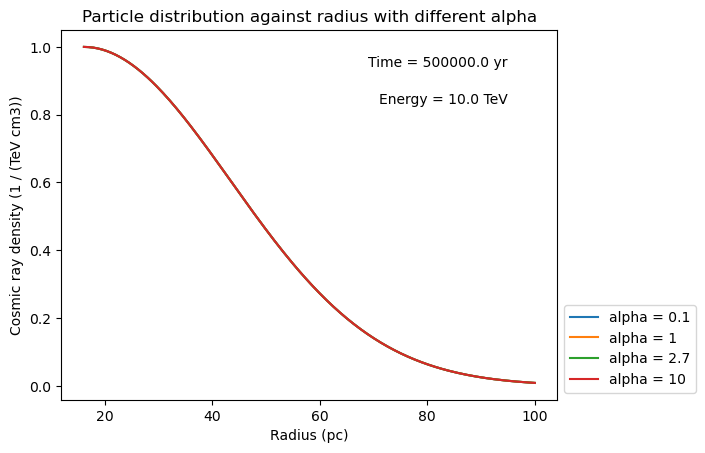

In [252]:
t = 5e5*u.yr
E = 10*u.TeV 

Rs = np.linspace(Rshell(E), 100*u.pc, 200)
print(Tesc(E))

alpha = [0.1, 1, 2.7, 10]

plt.figure()
for i in alpha:
    plt.plot(Rs, distribution(E, Rs, t, alpha = i)/np.max(distribution(E, Rs, t, alpha = i)), label=f"alpha = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E, Rs[0], t).unit})")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius with different alpha")


Changing beta against energy at different t

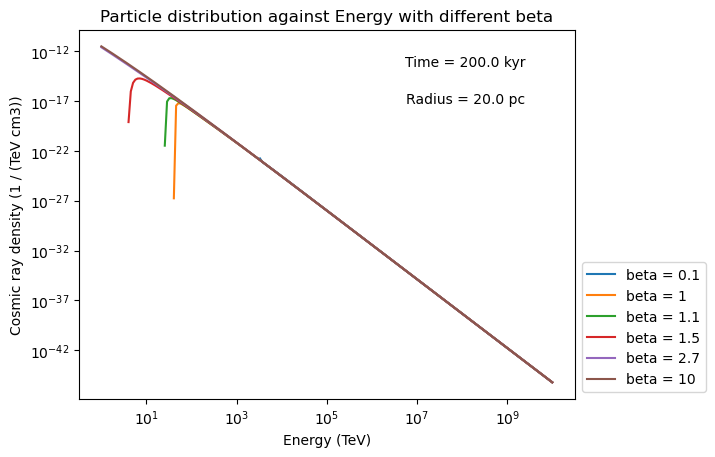

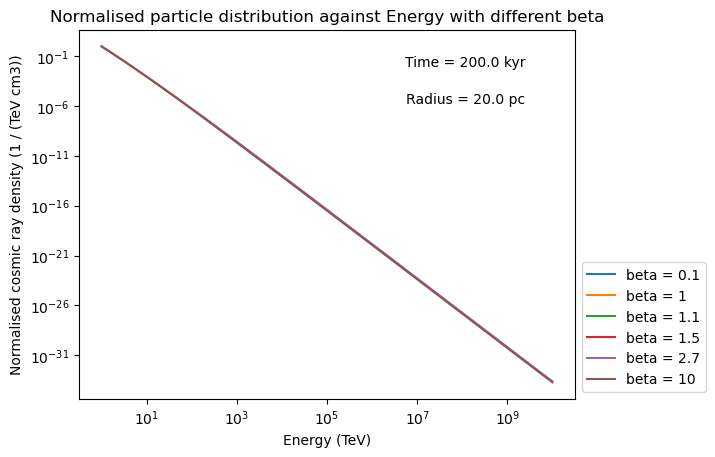

In [253]:
t = 200*u.kyr
R = 20*u.pc 

beta = [0.1, 1, 1.1, 1.5, 2.7, 10]

plt.figure()
for i in beta:
    plt.plot(Es, distribution(Es, R, t, beta = i), label=f"beta = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Energy ({Es.unit})")
plt.ylabel(f"Cosmic ray density ({distribution([Es]*u.TeV, R, t).unit})")

plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against Energy with different beta")

plt.yscale("log")
plt.xscale("log")

plt.figure()
for i in beta:
    plt.plot(Es, distribution(Es, R, t, beta = i)/np.max(distribution(Es, R, t, beta = i)), label=f"beta = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Energy ({Es.unit})")
plt.ylabel(f"Normalised cosmic ray density ({distribution([Es]*u.TeV, R, t).unit})")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Radius = {R}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Normalised particle distribution against Energy with different beta")

plt.yscale("log")
plt.xscale("log")


beta chnaging with radius

Text(0.5, 1.0, 'Particle distribution against radius with different beta')

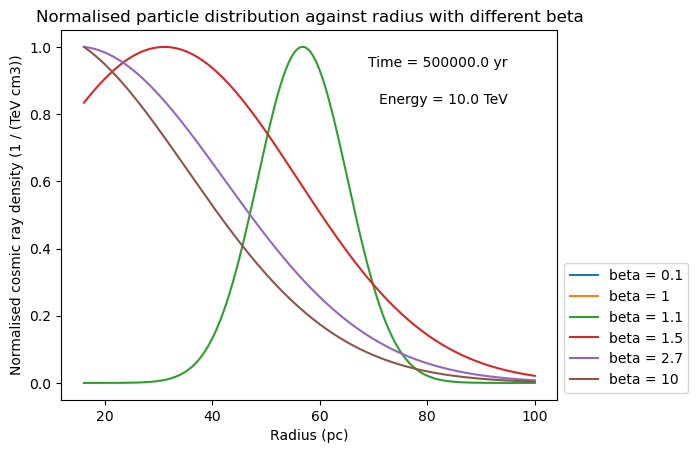

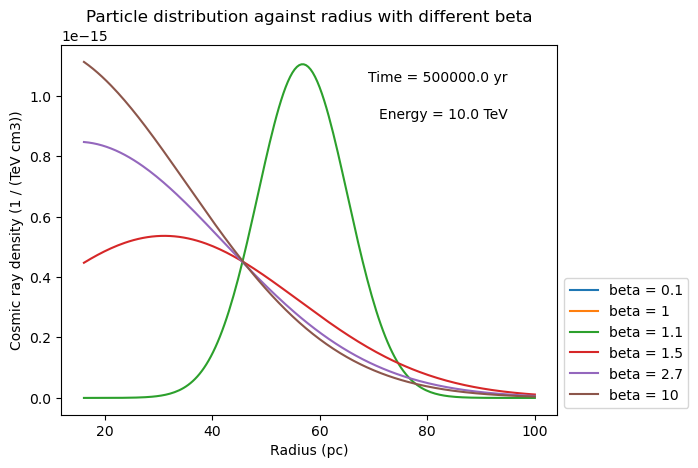

In [254]:
t = 5e5*u.yr
E = 10*u.TeV 

Rs = np.linspace(Rshell(E), 100*u.pc, 200)

beta = [0.1, 1, 1.1, 1.5, 2.7, 10]

plt.figure()
for i in beta:
    plt.plot(Rs, distribution(E, Rs, t, beta = i)/np.max(distribution(E, Rs, t, beta = i)), label=f"beta = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Normalised cosmic ray density ({distribution(E, Rs, t).unit})")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Normalised particle distribution against radius with different beta")


plt.figure()
for i in beta:
    plt.plot(Rs, distribution(E, Rs, t, beta = i), label=f"beta = {i}")

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel(f"Radius ({Rs.unit})")
plt.ylabel(f"Cosmic ray density ({distribution(E, Rs[0], t).unit})")
plt.text(0.9, 0.9, f"Time = {t}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.text(0.9, 0.8, f"Energy = {E}", transform = plt.gca().transAxes, horizontalalignment="right")
plt.title("Particle distribution against radius with different beta")

plot function for variables

In [261]:
def plotVar(xaxis, perameter, variablespace, perameter_name):
    t = 5e5 * u.yr
    E = 10 * u.TeV
    R = 50 * u.pc

    Rs = np.linspace(Rshell(E), 100 * u.pc, 200)
    Es = np.logspace(0, 10, 200) * u.TeV
    ts = np.linspace(Tesc(E).to(u.kyr).value, (50 * u.kyr).to(u.kyr).value, 200)*u.kyr

    # Choose axis based on xaxis variable
    if xaxis == 'R':
        axis = Rs
        R = Rs  # Update R to match axis
        xaxis_label = 'Radius'
    elif xaxis == 'E':
        axis = Es
        E = Es  # Update E to match axis
        xaxis_label = 'Energy'
    elif xaxis == 't':
        axis = ts
        t = ts  # Update t to match the axis
        xaxis_label = 'Time'
    else:
        raise ValueError("xaxis should be one of 'R', 'E', or 't'.")
    plt.figure()

    # Loop over the values in the variable space and update the desired parameter
    for i in variablespace:
        kwargs = {perameter_name: i}
        dist = distribution(E, R, t, **kwargs)  # Pass dynamic parameter using **kwargs
        plt.plot(axis, dist / np.max(dist), label=f"{perameter_name} = {i}")

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.xlabel(f"{xaxis_label} ({axis.unit})")
    plt.ylabel(f"Normalised cosmic ray density ({distribution(E, R, t).unit})")
    # plt.text(0.9, 0.9, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
    # plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")
    plt.title(f"Normalised particle distribution against {xaxis_label} with varying {perameter_name}")

    if xaxis == 'R':
        plt.text(0.9, 0.9, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 'E':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 't':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")

    if(xaxis_label == 'Energy'):
        plt.yscale("log")
        plt.xscale("log")
        

    plt.figure()

    # Plot without normalization for comparison
    for i in variablespace:
        kwargs = {perameter_name: i}
        dist = distribution(E, R, t, **kwargs)
        plt.plot(Rs, dist, label=f"{perameter_name} = {i}")

    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.xlabel(f"{xaxis_label} ({axis.unit})")
    plt.ylabel(f"Cosmic ray density ({distribution(E, R, t).unit})")
    plt.title(f"Particle distribution against {xaxis_label} with varying {perameter_name}")
    if xaxis == 'R':
        plt.text(0.9, 0.9, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 'E':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Time = {t}", transform=plt.gca().transAxes, horizontalalignment="right")
    elif xaxis == 't':
        plt.text(0.9, 0.9, f"Radius = {R}", transform=plt.gca().transAxes, horizontalalignment="right")
        plt.text(0.9, 0.8, f"Energy = {E}", transform=plt.gca().transAxes, horizontalalignment="right")

    if(xaxis_label == 'Energy'):
        plt.yscale("log")
        plt.xscale("log")


C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\aiden\anaconda3\envs\pracs\Lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


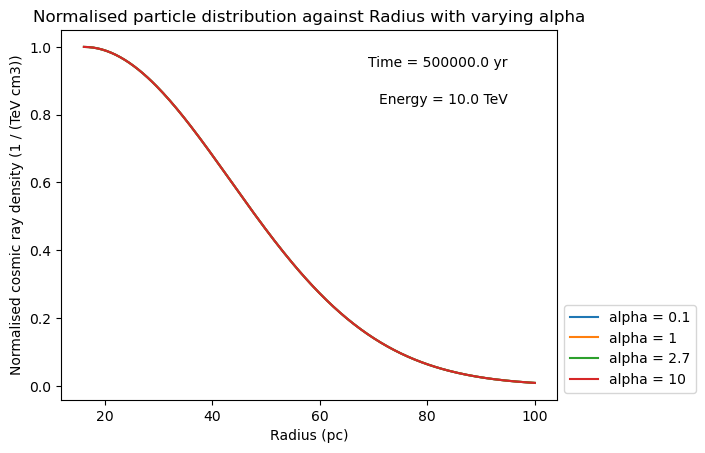

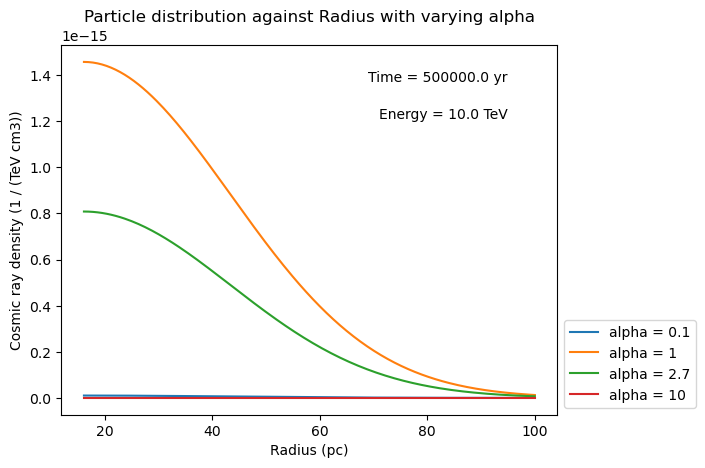

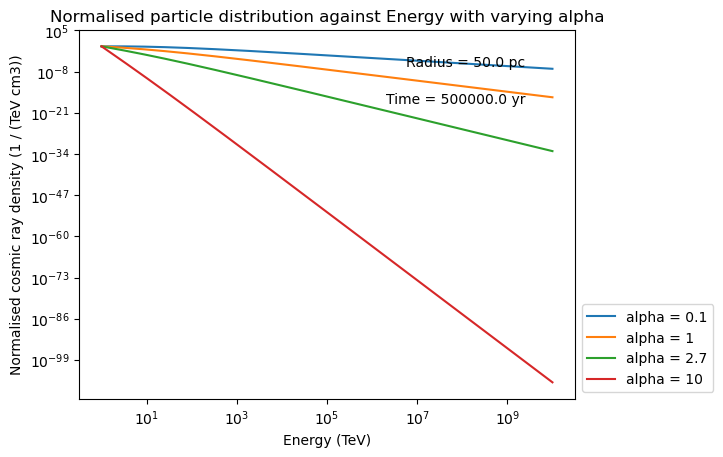

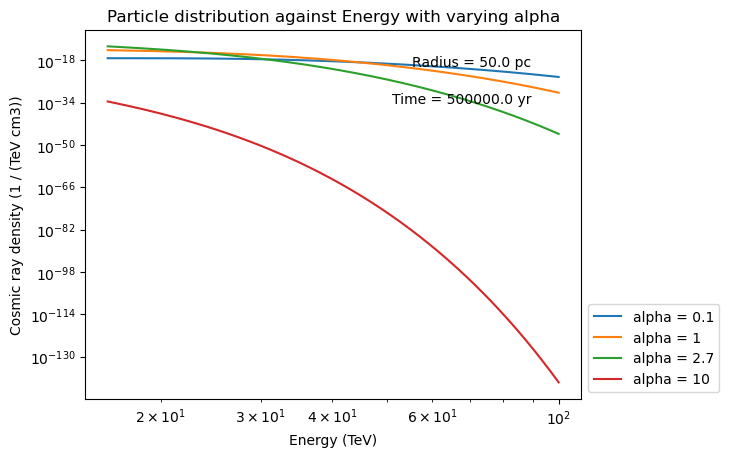

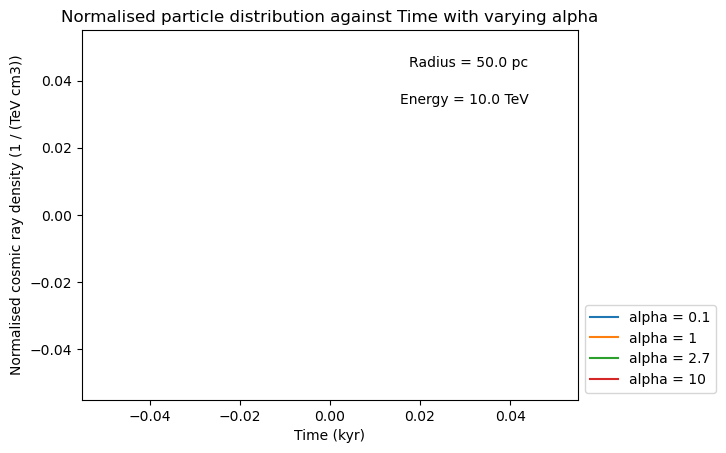

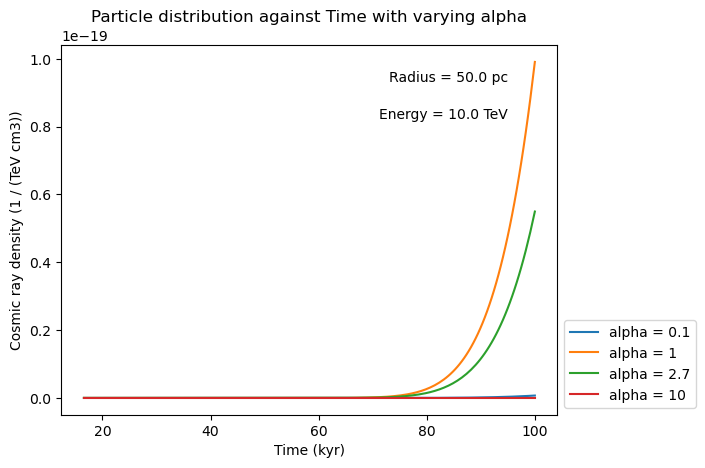

In [262]:
plotVar('R', alpha, [0.1, 1, 2.7, 10], 'alpha')
plotVar('E', alpha, [0.1, 1, 2.7, 10], 'alpha')
plotVar('t', alpha, [0.1, 1, 2.7, 10], 'alpha')
